In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


In [ ]:
# 생성자 만들기
generator = keras.models.Sequential()
generator.add(Dense(128*7*7, input_dim = 100, activation = LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size = 5, padding='same', activation='tanh'))

In [ ]:
# 판별자 모델
discriminator = keras.models.Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28, 28, 1), padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding = 'same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss = 'binary_crossentropy', optimizer='adam')
discriminator.trainable = False

In [ ]:
# 생성자와 판별자 모델을 연결시키는 gan 모델 만들기
ginput = Input(shape=(100,))

dis_output = discriminator(generator(ginput))
gan = keras.models.Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_5 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


epoch:0 d_loss:0.0022  g_loss:0.0000
epoch:1 d_loss:0.0006  g_loss:0.0000
epoch:2 d_loss:0.0000  g_loss:0.0000
epoch:3 d_loss:0.0000  g_loss:0.0000
epoch:4 d_loss:0.0000  g_loss:0.0000
epoch:5 d_loss:0.0000  g_loss:0.0000
epoch:6 d_loss:0.0000  g_loss:0.0000
epoch:7 d_loss:0.0000  g_loss:0.0000
epoch:8 d_loss:0.0000  g_loss:0.0000
epoch:9 d_loss:0.0000  g_loss:0.0000
epoch:10 d_loss:0.0000  g_loss:0.0000
epoch:11 d_loss:0.0000  g_loss:0.0000
epoch:12 d_loss:0.0000  g_loss:0.0000
epoch:13 d_loss:0.0000  g_loss:0.0000
epoch:14 d_loss:0.0000  g_loss:0.0000
epoch:15 d_loss:0.0000  g_loss:0.0000
epoch:16 d_loss:0.0000  g_loss:0.0000
epoch:17 d_loss:0.0000  g_loss:0.0000
epoch:18 d_loss:0.0000  g_loss:0.0000
epoch:19 d_loss:0.0000  g_loss:0.0000
epoch:20 d_loss:0.0000  g_loss:0.0000
epoch:21 d_loss:0.0000  g_loss:0.0000
epoch:22 d_loss:0.0000  g_loss:0.0000
epoch:23 d_loss:0.0000  g_loss:0.0000
epoch:24 d_loss:0.0000  g_loss:0.0000
epoch:25 d_loss:0.0000  g_loss:0.0000
epoch:26 d_loss:0.0000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


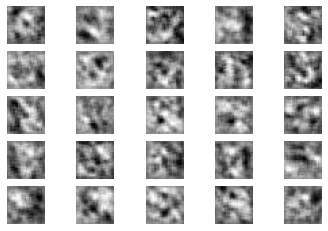

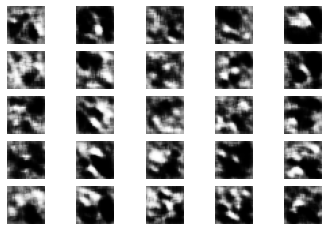

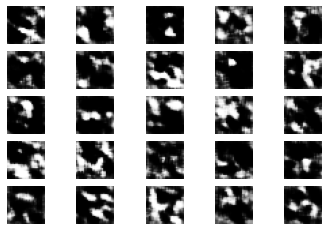

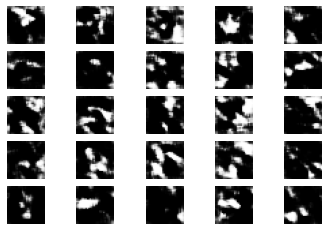

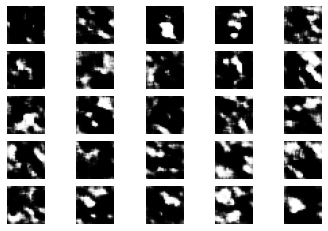

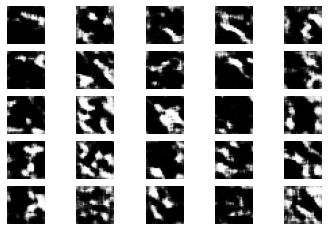

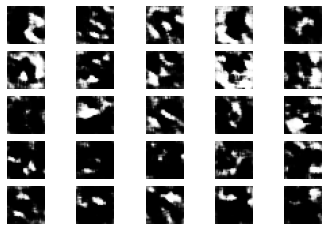

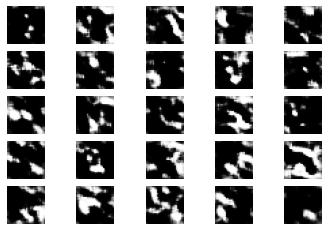

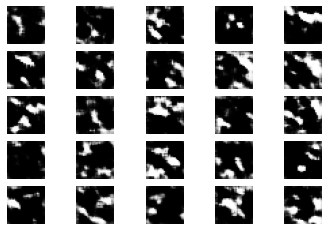

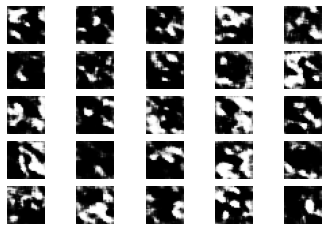

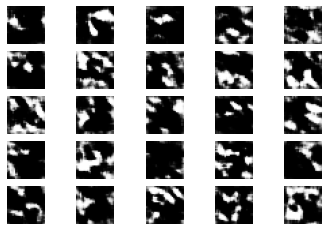

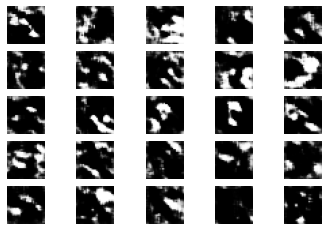

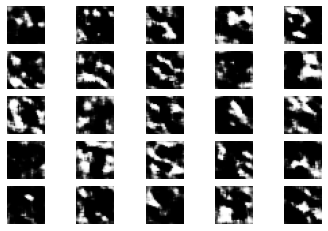

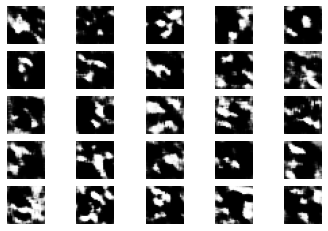

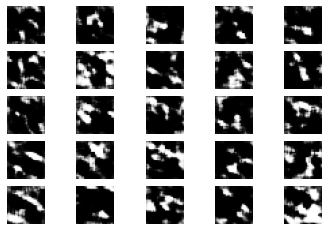

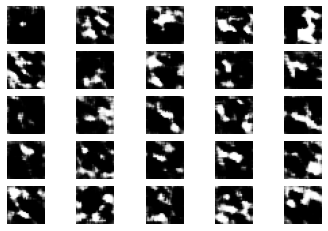

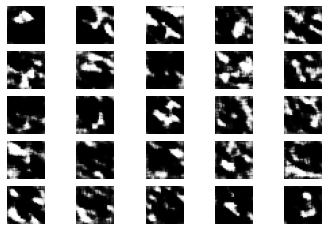

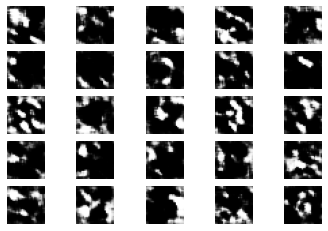

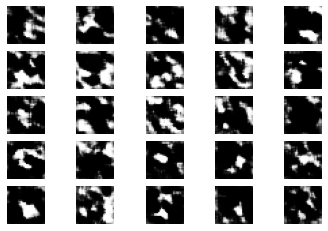

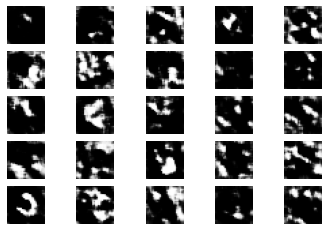

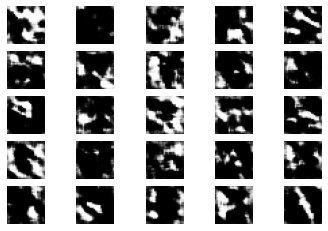

In [ ]:
# 신경망을 실행시키는 함수 만들기
def gan_train(epoch, batch_size, saving_interval):

    # MNIST 이미지를 다시 이용하기 위해서, x_train만 호출
    (x_train, _),(_, _) = keras.datasets.mnist.load_data() 
    # 127.5를 빼준 뒤, 127.5로 나눠서 -1 ~ +1사이의 값으로 바꿔준다.
    x_train = ((x_train-127.5)/127.5).reshape(-1, 28, 28, 1)

    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for i in range(epoch):
        # 실제 데이터를 판별자에 입력
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)

        # 가상 이미지를 판별자에 입력
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

        # 판별자와 생성자의 오차 계산
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)

        print('epoch:%d' % i, 'd_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 중간 과정을 이미지로 저장하는 부분, 정해진 인터벌만큼 학습되면 
        # 그 때 만든 이미지를 gan images 폴더에 저장하라는 뜻,
        # 이 코드는 본 장의 주된 목표와는 관계가 없어서 소스 코드만 적는다.

        if i % saving_interval == 0:
            # r,c = 5, 5
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)

            #Rescale images 0 ~ 1
            gen_imgs = 0.5 * gen_imgs + 0.5

            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap = 'gray')
                    axs[j, k].axis('off')
                    count += 1
                    fig.savefig('gan_images/gan_mnist_%d.png' % i)

# 4000번 반복되고(+1하는 것에 주의) 배치 크기는 32, 200번마다 결과가 저장됨
gan_train(4001, 32, 200)